# VT Hunting Domain Relationship using MSTICpy

This Jupyter notebook allows to request VirusTotal for a specific domain name, url or an IP address and see samples that have relationship using MSTICpy. To use it you need the following package:
* pip install msticpy
* pandas
* textsearch
* ipywidget

To use the VT_lookup module you need to add your VTI API in the msticpyconfig.yaml or modify the variable vt_key. 

Notes: The API can retrieve only 40 results, you have to specify the limit if you want to have less result. By default it is limited to 10 results. Be careful to your quota!

In [10]:
#----------------------------------------------------------------------------
# Author: Thomas Roccia
# Date: May 2022
# version = '1.0'
# ---------------------------------------------------------------------------

# Loading the VT API key and libs
from msticpy.common.provider_settings import get_provider_settings
from msticpy.sectools.vtlookupv3 import VTLookupV3, VTEntityType
from IPython.display import display, HTML
from textsearch import TextSearch
from IPython.display import display

import nest_asyncio
import re
import pandas as pd
import numpy as np
import ipywidgets as widgets

pd.set_option('display.max_colwidth', None)

# ADD YOUR VTI API HERE
# VT API Key https://developers.virustotal.com/reference/overview
# update msticpyconfig.yaml or uncomment the variable below with your own key. 
#vt_key =  "<YourAPIkey>"

# Get API key from mscticpyconfig, comment if you use the variable above
vt_key = get_provider_settings("TIProviders")["VirusTotal"].args["AuthKey"]

# Instantiate vt_lookup object
vt_lookup = VTLookupV3(vt_key)

nest_asyncio.apply()

In [15]:
# Get relationship for one domain

# Usage
display(HTML("<h2>Samples Hunting on domain/ip/url Relationship</h2"))
display(HTML("<h3>Usage: </h3"))
display(HTML("Enter the domain, url, ip, you want to search (e.g: 'anjian.com', '104.131.11.150')."))
display(HTML("Use the second box to apply a filter on your request, you can use regex, keyword or signature name (e.g: 'trojan|PUA', 'emotet', 'Trojan:Win64/Emotetcrypt')."))
display(HTML("By default the request will be limited to 10 results but you can increase it to 40. Be careful to your quota."))

# Search widget
keyword = widgets.Text(
    value='',
    placeholder='ip, domain, url...',
    description='Observable:',
    disabled=False
)
display(keyword)

keyword2 = widgets.Text(
    value='',
    placeholder='signature, keyword, family...',
    description='Filter:',
    disabled=False
)
display(keyword2)

# Slider for limit
limit = widgets.IntSlider(min = 1, max = 40, value = 10 , description='Limit:')
display(limit)


# Radio widget
selection = widgets.RadioButtons(
    options = ['downloaded_files', 'communicating_files'],
    description = 'Relationship:',
    disabled = False
)
display(selection)

# Radio widget
fileext = widgets.RadioButtons(
    options = ['all', 'peexe', 'pedll', 'doc', 'docx', 'ppt', 'pptx', 'xls', 'xlsx', 'html', 'xml', 'php', 'java', 'java-bytecode'],
    description = 'File type:',
    disabled = True
)
#display(fileext)

# Configure click button
button = widgets.Button(description="search", icon='check')
display(button)

# Display widget
output = widgets.Output()

searchResult = []
filetype = []

# Searching for the input word
@output.capture()
def userInput(b):
    
    # Regex
    validip = "^((25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])\.){3}(25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])$"
    validdomain = "^((?!-)[A-Za-z0-9-]" + "{1,63}(?<!-)\\.)" + "+[A-Za-z]{2,6}"
    validurl = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    
    # Compile the ReGex
    domain = re.compile(validdomain)
    ip = re.compile(validip)
    url = re.compile(validurl)
    
    print("[+] Searching VT samples that have relationship with: " + keyword.value)
    
    if re.search(ip, keyword.value):
        domain_relation = vt_lookup.lookup_ioc_relationships(observable = keyword.value, vt_type = 'ip_address', relationship = selection.value, limit = limit.value)
    elif re.search(domain, keyword.value):
        domain_relation = vt_lookup.lookup_ioc_relationships(observable = keyword.value, vt_type = 'domain', relationship = selection.value, limit = limit.value)
    elif re.search(url, keyword.value):
        domain_relation = vt_lookup.lookup_ioc_relationships(observable = keyword.value, vt_type = 'url', relationship = selection.value, limit = limit.value)
    else:
        print("[!] Not a valid ip, domain or url!")

    if keyword2.value: 
        for sample in domain_relation["target"]:

            hash_details = vt_lookup.get_object(sample, "file")
            search = hash_details.apply(lambda row: row.astype(str).str.contains(keyword2.value, regex = True, flags = re.IGNORECASE).any(), axis=1)
            
            if "magic" in hash_details.columns:
                filetype.append(hash_details["magic"])

            if search[0] != True:
                searchResult.append("False")
            else:
                searchResult.append("True")     

        domain_relation["magic"] = filetype
        domain_relation[keyword2.value] = searchResult

    display(domain_relation)


# get the input word
button.on_click(userInput)
display(output)

Text(value='', description='Observable:', placeholder='ip, domain, url...')

Text(value='', description='Filter:', placeholder='signature, keyword, family...')

IntSlider(value=10, description='Limit:', max=40, min=1)

RadioButtons(description='Relationship:', options=('downloaded_files', 'communicating_files'), value='download…

Button(description='search', icon='check', style=ButtonStyle())

Output()

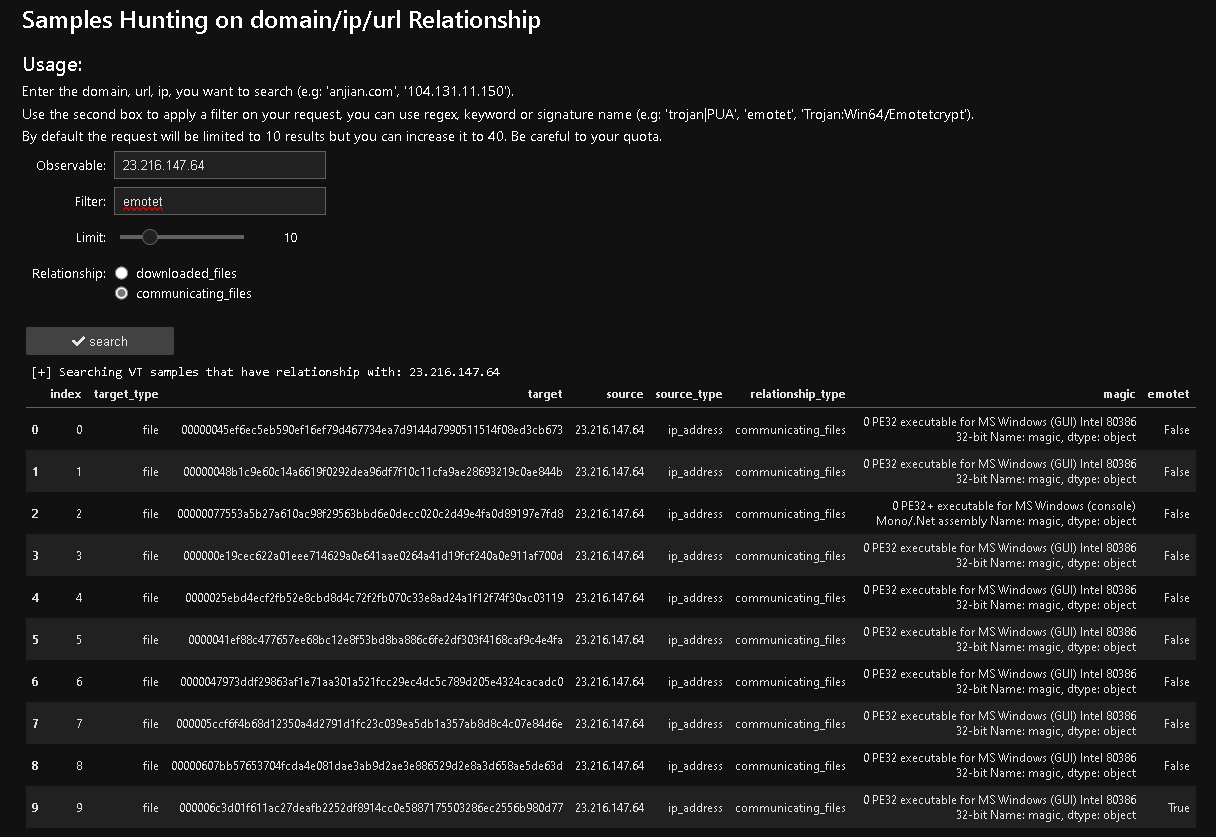

In [18]:
from IPython.display import Image
display(HTML("<h3> Example </h3>"))
Image(filename='example.png') 

# Contact
If you like this content, send a hug on Twitter for more stuff like this!

<a href="https://twitter.com/fr0gger_?ref_src=twsrc%5Etfw" class="twitter-follow-button" data-show-count="false">Follow @fr0gger_</a><script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>